In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA A100-SXM4-40GB'

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [6]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [8]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14});

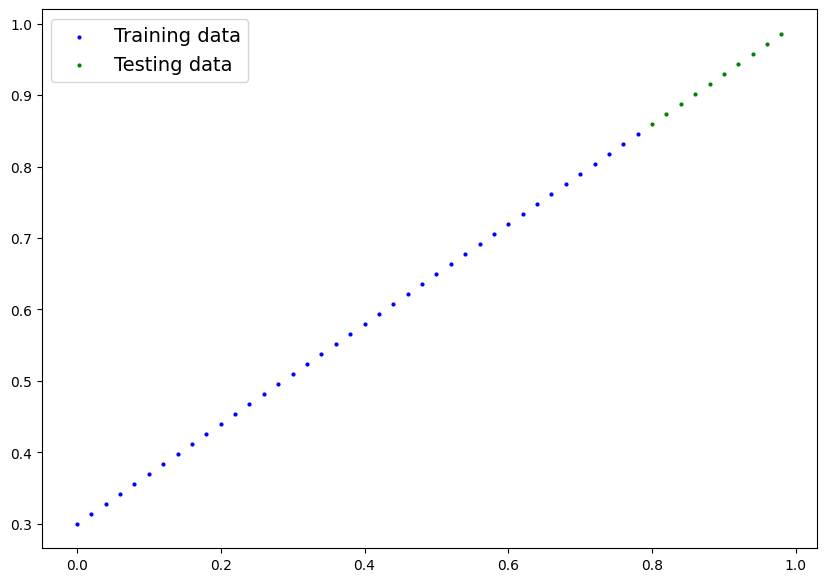

In [9]:
plot_predictions();

In [ ]:
class LRModel(nn.Module):
    def __init__(self):
        super().__init__()
        # required grads computes gradients automatically
        self.weights=nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias=nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    # this is each neuron output
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.weights*x+self.bias

There are 
- torch.nn -> graphs
- torch.Parameter -> parameter in layers
- torch.optim -> optimization algos
- torch.nn.Module -> Base class for NN, needs forward() to be implemented, essentilly the layers
- torch.utils.data.Dataset -> datasets
- torch.utils.data.DataLoader -> dataloader to load data

In [23]:
torch.manual_seed(0)
model_0 = LRModel()
# access layers
print(f'{list(model_0.parameters())}')
# get contens via dictionary
print(f'{model_0.state_dict()}')



[Parameter containing:
tensor([1.5410], requires_grad=True), Parameter containing:
tensor([-0.2934], requires_grad=True)]
OrderedDict([('weights', tensor([1.5410])), ('bias', tensor([-0.2934]))])


### Make Predictions
torch.inference mode is for predictions
torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference)

In [25]:
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.9394],
        [0.9702],
        [1.0010],
        [1.0318],
        [1.0626],
        [1.0935],
        [1.1243],
        [1.1551],
        [1.1859],
        [1.2167]])


tensor([[-0.0794],
        [-0.0962],
        [-0.1130],
        [-0.1298],
        [-0.1466],
        [-0.1635],
        [-0.1803],
        [-0.1971],
        [-0.2139],
        [-0.2307]])


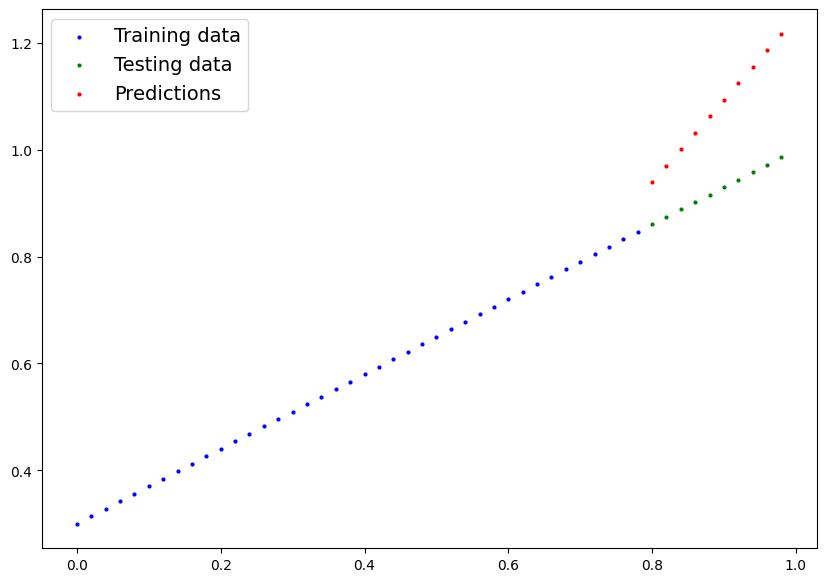

In [29]:
# very off!
plot_predictions(predictions=y_preds)
print(y_test-y_preds)

### Loss Function and Optimizer
- Loss Fcuntion -> measures your wrongdoings :3
    - torch.nn -> built in loss functions such as BCE or L1
- Optimizer -> The update part "going down the slope"/lowering loss
    - torch optim -> optimizer such as adam, sgd, etc

In [31]:
# Create the loss function
# MAE loss is same as L1Loss
loss_fn = nn.L1Loss() 

# params is the parameters of target model to optimize, in this case its w and b
# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
# essentially like going down a mountain by jumping or walking :3
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) 

Training Loop
1. Forward Pass
    - Calculates parameters forward
2. Calculating Loss
    - compare model prediction to the actual data
3. Zero Gradients
    - Optimizer gradients are set to zero, so they can be recalculated on each training step
4. Perform Backprop
    - Computes gradients of the loss with respect to the parameters
5. Update the Optimizer
    - Update the parameters(Gradient Descent), basically stpping towards the minimal loss area

Testing Loop (no need backprop here :3)
1. Forward Pass
    - Calculates parameters forward
2. Calculating Loss
    - compare model prediction to the actual data
5. Calculate Evaluation Metrics
    - Calculate accuracy and such

In [54]:
# torch.manual_seed(1)
epochs = 100
# init list needed for tracking
train_loss_values=[]
test_loss_values=[]
epoch_count =[]

# using a regular loop, we can just train it!
for epoch in range(epochs):
    # set model mode to training
    model_0.train()
    # Forward Pass
    y_pred = model_0(X_train)
    # Calculate how much we lose
    loss=loss_fn(y_pred, y_train)
    # Zero out the gradient in this step so it doesnt accumulate
    optimizer.zero_grad()
    # Backprop
    loss.backward()
    # Update parameters
    optimizer.step()
    
    # put model on ealuation mode
    model_0.eval()
    # using inference mode to calculate loss
    with torch.inference_mode():
        test_pred=model_0(X_test)
        # compare pred to actual value
        test_loss:nn.L1Loss=loss_fn(test_pred, y_test.type(torch.float))
        if epoch%10==0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy()) 
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 10 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 20 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 30 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 40 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 50 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 60 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 70 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 80 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 
Epoch: 90 | MAE Train Loss: 0.008941905573010445 | MAE Test Loss: 0.00515474658459425 


In [55]:
def plot_loss(epoch_count, train_loss_values, test_loss_values):
    plt.plot(epoch_count, train_loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

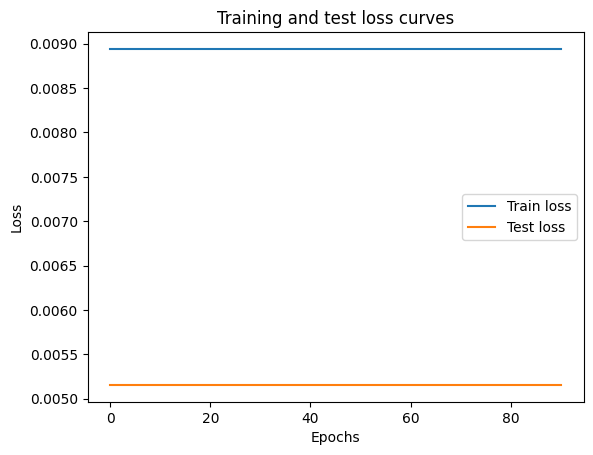

In [58]:
plot_loss(epoch_count, train_loss_values, test_loss_values)

In [59]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.7013])), ('bias', tensor([0.2906]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Predicitions
1. Set Mode to eval
2. Make predictions with inference mode - has to be both on gpu or cpu

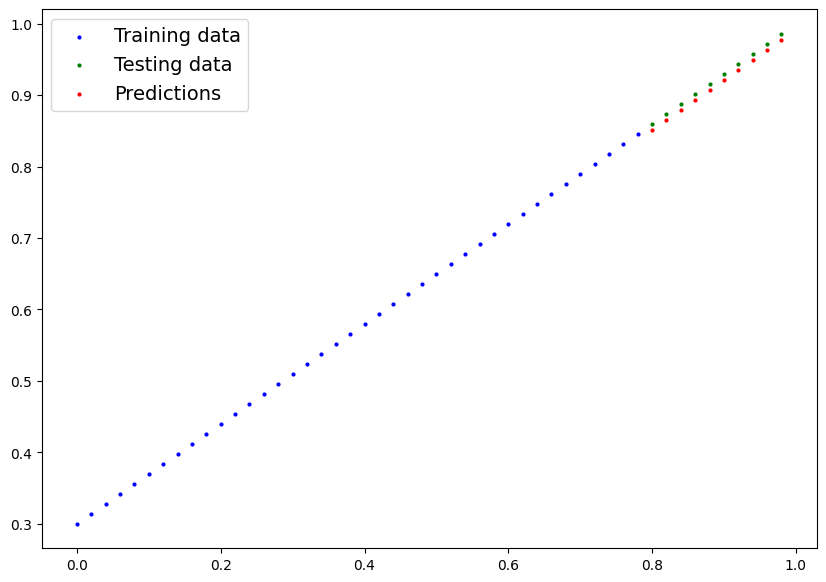

In [61]:
model_0.eval()
with torch.inference_mode():
    y_preds=model_0(X_test)
    plot_predictions(predictions=y_preds)

### Saving and loading models(uses pickle)
- torch.save()
- torch.load()
- torch.nn.Module.load_state_dict() -> load the parameter dictionary

In [62]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [63]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Feb 27 04:52 models/01_pytorch_workflow_model_0.pth


In [ ]:
# Loading model
# we call torch load because we only save the parameter dictionary
loaded_model_0 = LRModel()
# If you use strict=False in load_state_dict
# you inform PyTorch that the target model and the original model are not identical
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH), strict=True)

<All keys matched successfully>

In [73]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()
# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [72]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])